Import Libraries

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [74]:
data=pd.read_csv("/content/drive/MyDrive/Main Project/Models/Energy Consumption data site id 8.csv")

In [75]:
data['Date']=pd.to_datetime(data['Date'])
data['Timestamp']=pd.to_datetime(data['Timestamp'])
data.head()

,Date,Timestamp,year,Month,Temperature,Holiday,Is_Working_Day,Values
0,2013-03-21,2013-03-21 00:00:00+00:00,2013,3,13.0,Working Day,1,51.953817
1,2013-03-22,2013-03-22 00:00:00+00:00,2013,3,15.0,Working Day,1,42.459353
2,2013-03-23,2013-03-23 00:00:00+00:00,2013,3,15.0,Working Day,1,34.399994
3,2013-03-24,2013-03-24 00:00:00+00:00,2013,3,14.8,Working Day,1,35.669267
4,2013-03-25,2013-03-25 00:00:00+00:00,2013,3,19.0,Working Day,1,52.242278


Checking Data is non stationary

Null Hypothesis - Series Possses a unit root and hence is not stationary

Alternate Hypothesis -  Series is stationary

In [76]:
df=data[['Timestamp','Temperature','Is_Working_Day','Values']]
df.set_index('Timestamp',inplace=True)
df.head()

,Temperature,Is_Working_Day,Values
Timestamp,,,
2013-03-21 00:00:00+00:00,13.0,1,51.953817
2013-03-22 00:00:00+00:00,15.0,1,42.459353
2013-03-23 00:00:00+00:00,15.0,1,34.399994
2013-03-24 00:00:00+00:00,14.8,1,35.669267
2013-03-25 00:00:00+00:00,19.0,1,52.242278


In [77]:
for i in range(len(df.columns)):
  result = adfuller(df[df.columns[i]])

  if result[1] >0.05:
    print(df.columns[i],"is non stationary")
  else:
    print(df.columns[i],"is stationary")

#H0: Xt does not granger causes Yt
#H1: Xt granger causes Yt

Temperature is non stationary
Is_Working_Day is stationary
Values is stationary


In [78]:
df.loc[:, 'Temperature_diff'] = df['Temperature'].diff().dropna()
print("Check for NaNs:\n ",df.isnull().sum())
print("\nCheck for infinite values:\n",df.isin([np.inf, -np.inf]).sum())



Check for NaNs:
  Temperature         0
Is_Working_Day      0
Values              0
Temperature_diff    1
dtype: int64

Check for infinite values:
 Temperature         0
Is_Working_Day      0
Values              0
Temperature_diff    0
dtype: int64


<ipython-input-78-af7442ea7bcf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Temperature_diff'] = df['Temperature'].diff().dropna()


In [79]:
df_cleaned = df.dropna()
df_cleaned = df.fillna(method='ffill').fillna(method='bfill')
df_cleaned=df_cleaned.drop(['Temperature_diff'],axis=1)
df_cleaned.head()

<ipython-input-79-a69fdcba0b3e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df.fillna(method='ffill').fillna(method='bfill')


,Temperature,Is_Working_Day,Values
Timestamp,,,
2013-03-21 00:00:00+00:00,13.0,1,51.953817
2013-03-22 00:00:00+00:00,15.0,1,42.459353
2013-03-23 00:00:00+00:00,15.0,1,34.399994
2013-03-24 00:00:00+00:00,14.8,1,35.669267
2013-03-25 00:00:00+00:00,19.0,1,52.242278


In [80]:
print("Check for NaNs:\n ",df_cleaned.isnull().sum())

Check for NaNs:
  Temperature       0
Is_Working_Day    0
Values            0
dtype: int64


In [81]:
max_lags = 8
y='Values'

for i in range(len(df_cleaned.columns)):
    if df_cleaned.columns[i] != y:
        results = grangercausalitytests(df_cleaned[[df_cleaned.columns[i], y]], max_lags, verbose=False)
        p_values = [round(results[j+1][0]['ssr_ftest'][1], 4) for j in range(max_lags)]
        print(f'Column - {df_cleaned.columns[i]}  P_Values - {p_values}')

Column - Temperature  P_Values - [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002, 0.0014]
Column - Is_Working_Day  P_Values - [0.0102, 0.0182, 0.0191, 0.0197, 0.025, 0.0347, 0.1184, 0.1578]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [82]:
df_new=df_cleaned.drop(['Is_Working_Day'],axis=1)
print(df_new)
df_train =df_new.iloc[:int(0.8*(len(df_cleaned)))]
df_test = df_new.iloc[int(0.8*(len(df_cleaned))):]

                           Temperature     Values
Timestamp                                        
2013-03-21 00:00:00+00:00        13.00  51.953817
2013-03-22 00:00:00+00:00        15.00  42.459353
2013-03-23 00:00:00+00:00        15.00  34.399994
2013-03-24 00:00:00+00:00        14.80  35.669267
2013-03-25 00:00:00+00:00        19.00  52.242278
...                                ...        ...
2017-03-01 00:00:00+00:00        17.00  31.927374
2017-03-02 00:00:00+00:00        17.00  30.958712
2017-03-03 00:00:00+00:00        16.00  31.299375
2017-03-04 00:00:00+00:00        15.75  17.386416
2017-03-05 00:00:00+00:00        15.40  16.265874

[1446 rows x 2 columns]


In [83]:
print("Shape of Train :",df_train.shape)
print("Shape of Test :",df_test.shape)

Shape of Train : (1156, 2)
Shape of Test : (290, 2)


$y_{1,t}$ = $C_{1}$ +$a_{1,1}$ $y_{1,t-1}$ +$a_{1,2}$ $y_{2,t-1}$ +$e_{1,t}$  

In [95]:
model= VAR(df_train, freq='D')
for i in range(48):
  result_m=model.fit(i+1)
  print('Order =',i+1)
  print('AIC : ',result.aic)
  print('BIC : ',result.bic)

Order = 1
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 2
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 3
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 4
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 5
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 6
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 7
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 8
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 9
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 10
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 11
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 12
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 13
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 14
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 15
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 16
AIC :  5.310975410995212
BIC :  6.188232181985828
Order = 17
AIC :  5.3109754109952

In [85]:
model.select_order(48).summary()

,AIC,BIC,FPE,HQIC
0,8.242,8.251,3799.,8.246
1,6.526,6.553,682.4,6.536
2,6.432,6.478,621.6,6.449
3,6.371,6.435,584.9,6.395
4,6.359,6.440,577.7,6.390
5,6.270,6.370,528.6,6.308
6,5.836,5.953,342.3,5.880
7,5.584,5.720,266.2,5.636
8,5.401,5.555*,221.7,5.459
9,5.385,5.557,218.2,5.450


In [86]:
model = VAR(df_train, freq='D')
model_fit = model.fit(8)

In [102]:
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Aug, 2024
Time:                     05:20:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.54845
Nobs:                     1148.00    HQIC:                   5.45543
Log likelihood:          -6322.92    FPE:                    221.189
AIC:                      5.39901    Det(Omega_mle):         214.780
--------------------------------------------------------------------
Results for equation Temperature
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  3.431665         0.620739            5.528           0.000
L1.Temperature         0.681841         0.029627           23.015           0.000
L1.Values             -0.013416         0.013042  

In [103]:
lag=model_fit.k_ar

In [104]:
model_fit.forecast(df_train.values[-lag:],steps=5)

array([[11.76481519, 38.96347736],
       [12.11660716, 20.75125179],
       [12.29701773, 24.07034723],
       [12.24390631, 47.56700691],
       [12.15283569, 50.45425462]])

In [99]:
df_test[0:5]

,Temperature,Values
Timestamp,,
2016-05-20 00:00:00+00:00,10.0,40.178215
2016-05-21 00:00:00+00:00,10.0,28.743052
2016-05-22 00:00:00+00:00,8.0,24.418386
2016-05-23 00:00:00+00:00,7.0,55.051060
2016-05-24 00:00:00+00:00,8.0,52.779598


Mean Absolute Error (MAE): 12.447955774054371
Mean Squared Error (MSE): 202.9514884786968
Root Mean Squared Error (RMSE): 14.246104326400843
R2_Score:0.08737747025500608


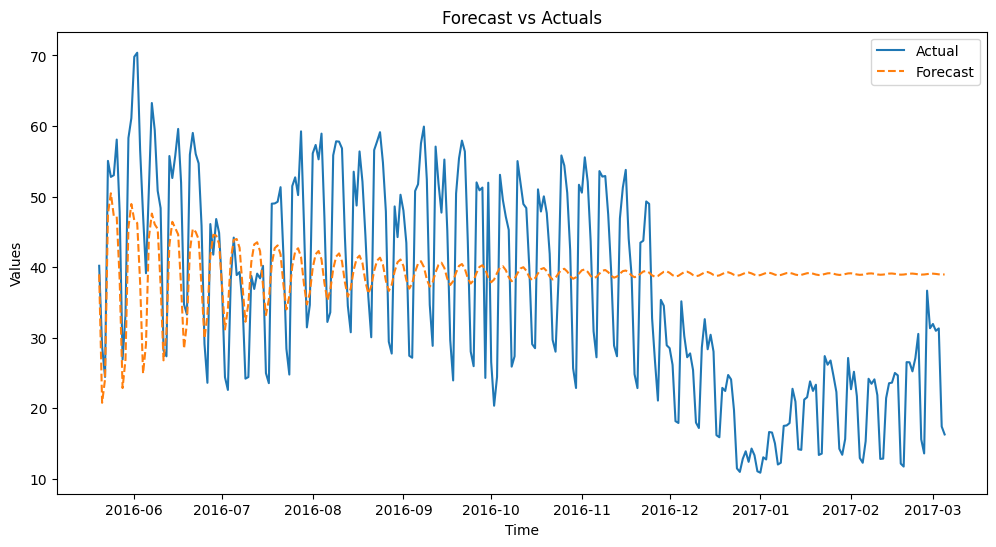

In [124]:
lag = model_fit.k_ar
forecast = model_fit.forecast(df_train.values[-lag:], steps=len(df_test))

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=df_test.index, columns=df_test.columns)

# Compare Forecasts with Actual Values
actual = df_test['Values']
predicted = forecast_df['Values']

# Calculate Forecast Errors
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
r2=r2_score(actual, predicted)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R2_Score:{r2}')

# Plot Forecasts vs. Actuals
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, actual, label='Actual')
plt.plot(df_test.index, predicted, label='Forecast', linestyle='--')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


In [105]:
df_coeff=pd.DataFrame([model_fit.params['Values'],model_fit.pvalues['Values']]).T

In [106]:
df_coeff

,Values,Values
const,3.769934,3.725394e-03
L1.Temperature,-0.093352,1.323623e-01
L1.Values,0.646422,6.990252e-124
L2.Temperature,-0.036498,6.275333e-01
L2.Values,-0.094837,4.738726e-04
L3.Temperature,0.081981,2.794467e-01
L3.Values,0.020530,4.438112e-01
L4.Temperature,-0.052327,4.913874e-01
L4.Values,0.013474,6.140993e-01
L5.Temperature,0.000468,9.950996e-01


In [108]:
df_coeff.columns=['coeff','pvalues']

In [110]:
df_coeff.query('pvalues <0.05')
np.where(df_coeff['pvalues']<0.05,1,0)

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1])

In [112]:
df_coeff['vaild']=np.where(df_coeff['pvalues']<0.05,1,0)
df_coeff

,coeff,pvalues,vaild
const,3.769934,3.725394e-03,1
L1.Temperature,-0.093352,1.323623e-01,0
L1.Values,0.646422,6.990252e-124,1
L2.Temperature,-0.036498,6.275333e-01,0
L2.Values,-0.094837,4.738726e-04,1
L3.Temperature,0.081981,2.794467e-01,0
L3.Values,0.020530,4.438112e-01,0
L4.Temperature,-0.052327,4.913874e-01,0
L4.Values,0.013474,6.140993e-01,0
L5.Temperature,0.000468,9.950996e-01,0


In [113]:
coeff_arr=df_coeff['coeff'][1:].values

In [114]:
coeff_arr.shape

(16,)

In [115]:
coeff_arr

array([-9.33517739e-02,  6.46422336e-01, -3.64977001e-02, -9.48367091e-02,
        8.19809637e-02,  2.05295776e-02, -5.23272204e-02,  1.34738664e-02,
        4.67511092e-04, -8.25579526e-02, -5.94544119e-02,  1.71120017e-01,
        5.02513229e-02,  6.54991322e-01,  1.45758553e-02, -3.97552894e-01])

In [116]:
df_train[-lag:]

,Temperature,Values
Timestamp,,
2016-05-12 00:00:00+00:00,17.6,53.781787
2016-05-13 00:00:00+00:00,14.0,42.731838
2016-05-14 00:00:00+00:00,16.5,19.885812
2016-05-15 00:00:00+00:00,13.0,21.035606
2016-05-16 00:00:00+00:00,14.9,50.288528
2016-05-17 00:00:00+00:00,9.0,52.240253
2016-05-18 00:00:00+00:00,11.0,48.053067
2016-05-19 00:00:00+00:00,11.0,48.283701


In [117]:
in_arr=df_train[-lag:][::-1].stack().to_frame().T.values

In [118]:
in_arr.shape

(1, 16)

In [119]:
in_arr

array([[11.        , 48.28370089, 11.        , 48.05306705,  9.        ,
        52.24025256, 14.9       , 50.28852775, 13.        , 21.03560637,
        16.5       , 19.8858123 , 14.        , 42.73183807, 17.6       ,
        53.78178666]])

In [120]:
np.dot(in_arr, coeff_arr)+ df_coeff['coeff'][:1].values

array([38.96347736])